# Bidirectional Encoder Representations from Transformers

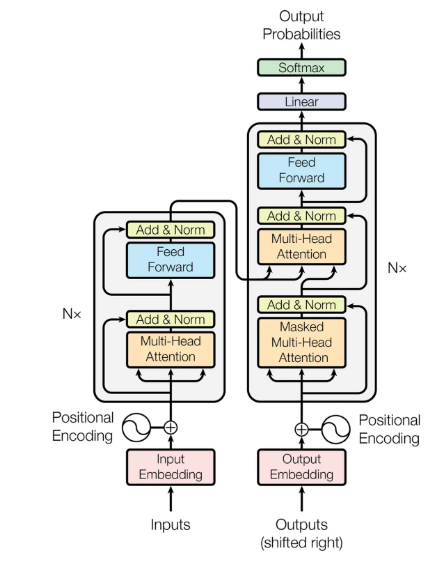

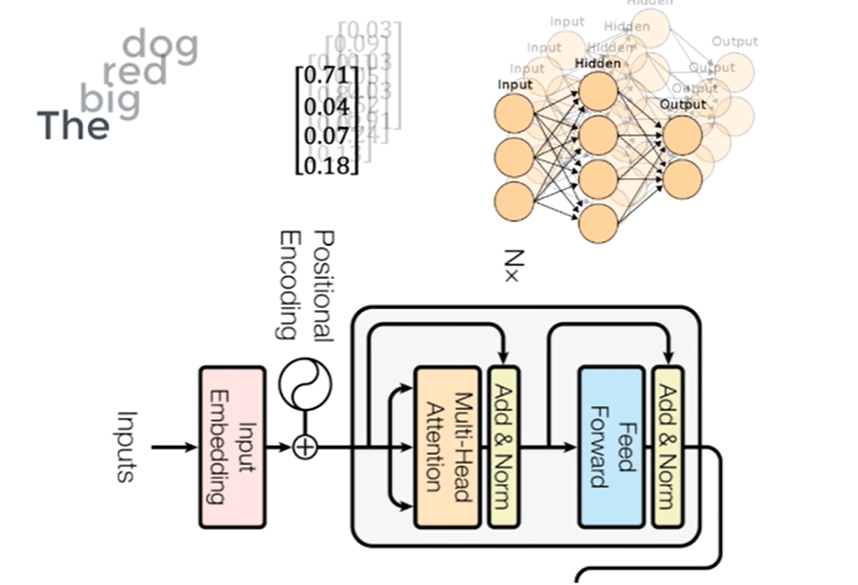

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import time


In [ ]:

# Load CSV dataset
df = pd.read_csv("/content/dp_best.csv", header=None)  # Assuming no header is provided


# changing to lowercase
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].str.replace('\n',' ', regex=True)

# removing all the punctuations
df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].str.replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df[0] = df[0].apply(lambda text: cleaning_stopwords(text))

df[0].head()

nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df[0] = df[0].apply(lemmatize_text)

sentiment_mapping = {
    'Shaming': 0,
    'False Urgency': 1,
    'Nagging': 2,
    'Subscription Trap': 3,
    'Basket Sneaking': 4,
    'Not Dark Pattern':5
}
df[1] = df[1].map(sentiment_mapping)


In [ ]:

# Split dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize text and encode labels
def tokenize_data(df):
    inputs = tokenizer(df[0].tolist(), padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(df[1].tolist())
    return inputs, labels

train_inputs, train_labels = tokenize_data(train_df)
test_inputs, test_labels = tokenize_data(test_df)

# Save the tokenizer
tokenizer.save_pretrained("bert_tokenizer")

In [ ]:
# Create data loaders
train_dataset = TensorDataset(train_inputs["input_ids"], train_inputs["attention_mask"], train_labels)
test_dataset = TensorDataset(test_inputs["input_ids"], test_inputs["attention_mask"], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=6)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
# Fine-tune the model
optimizer = AdamW(model.parameters(), lr=2e-5)
model.train()
for epoch in range(5):  # Adjust number of epochs as needed
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Save the fine-tuned model
model.save_pretrained("bert_sequence_classification_model")


<ipython-input-1-fef56f5c3fb5>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)
<ipython-input-1-fef56f5c3fb5>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s]',' ')
<ipython-input-1-fef56f5c3fb5>:31: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/t

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Load the model for inference on CPU
loaded_model = BertForSequenceClassification.from_pretrained("bert_sequence_classification_model")
loaded_model.eval()

# Load the tokenizer for inference
loaded_tokenizer = BertTokenizer.from_pretrained("bert_tokenizer")

In [ ]:
# Inference on the test set
predictions = []
true_labels = []
inference_times = []  # List to store inference times
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch

        # Measure inference time
        start_time = time.time()

        outputs = loaded_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        end_time = time.time()

        inference_time = end_time - start_time
        inference_times.append(inference_time)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# Calculate average inference time
avg_inference_time = sum(inference_times) / len(inference_times)
print(f"Average Inference Time per Datapoint: {avg_inference_time} seconds")


Accuracy: 0.930841121495327
Average Inference Time per Datapoint: 2.2511917142307056 seconds


In [ ]:
!zip -r /content/bert_sequence_classification_model.zip /content/bert_sequence_classification_model


  adding: content/bert_sequence_classification_model/ (stored 0%)
  adding: content/bert_sequence_classification_model/config.json (deflated 54%)
  adding: content/bert_sequence_classification_model/model.safetensors (deflated 7%)


In [ ]:
!zip -r /content/bert_tokenizer.zip /content/bert_tokenizer


  adding: content/bert_tokenizer/ (stored 0%)
  adding: content/bert_tokenizer/vocab.txt (deflated 53%)
  adding: content/bert_tokenizer/tokenizer_config.json (deflated 75%)
  adding: content/bert_tokenizer/special_tokens_map.json (deflated 42%)
